# Discovering Liparulo and Shoemaker, 2024 model using Robinson et al., 2011 Dataset

In [1]:
#importing existing dataset and generating samples
using CSV, DataFrames
using Pkg
using XLSX
project_root_dir = dirname(Pkg.project().path)
viral_load_path = joinpath(project_root_dir, "Data-Master", "Viral Load.xlsx")
states_path = joinpath(project_root_dir, "Data-Master", "States.xlsx")

df_viral_load = XLSX.openxlsx(viral_load_path) do xf
    sh   = xf["Robinson et al., IL17..."]     # sheet by name
    df  = DataFrame(XLSX.gettable(sh))
end

df_states = XLSX.openxlsx(states_path) do xf
    sh   = xf["Robinson et al., IL17..."]     # sheet by name
    df  = DataFrame(XLSX.gettable(sh))
end

Row,Time (Days),n,Sex,Viral Strain,Mice Species,CCL2,CCL2stdev,CCL2Norm,CCL3,CCL3stdev,CCL3Norm,IFNb,IFNbstdev,IFNbNorm,IFNg,IFNgstdev,IFNgNorm,IL-1b,IL-1bstdev,IL-1bNorm,IL-6,IL-6stdev,IL-6Norm,IL-10,IL-10stdev,IL-10Norm,IL-12(p70),IL-12(p70)stdev,IL-12(p70)Norm,TNF-a,TNF-astdev,TNF-aNorm,TGF-b1,TGF-b1stdev,TGF-b1Norm
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,10,M,PR8,C57BL/6,2.01,0.37,0.0596,1.53,0.25,0.0587049,1.02,0.31,0.05,1.5,0.41,0.0503892,1.3,0.14,0.333146,1.41,0.24,0.0521183,5.51,1.79,0.102822,2.2,0.49,0.518367,1.64,0.14,0.0695451,1.25,0.15,0.493836
2,3,10,M,PR8,C57BL/6,13.46,1.63,0.115,9.16,1.39,0.144963,6.86,0.03,0.6989,27.57,4.67,0.0571529,2.1,0.15,0.73764,41.98,3.75,0.113945,2.27,0.56,0.0715915,1.58,0.26,0.328571,15.51,2.18,0.252715,0.88,0.09,0.265753
3,5,10,M,PR8,C57BL/6,30.74,3.86,0.1987,24.96,5.54,0.323584,7.83,0.82,0.8067,22.08,4.32,0.0557286,2.52,0.15,0.95,48.88,2.75,0.12446,2,0.42,0.068989,1,0.18,0.15102,20.58,1.71,0.31967,1.21,0.09,0.469178
4,7,10,M,PR8,C57BL/6,39.83,1.13,0.2427,80.37,9.66,0.95,5.61,0.47,0.56,705.24,56.84,0.232972,2.07,0.21,0.722472,37,2.68,0.106356,16.49,1.97,0.208659,1.95,0.24,0.441837,36.598,2.58,0.531206,0.94,0.13,0.30274
5,1,10,F,PR8,C57BL/6,2.42,0.33,0.0616,0.77,0.12,0.0501131,1.47,0.17,0.1,0.91,0.14,0.0502361,0.76,0.05,0.0601124,1.39,0.3,0.0520878,1.56,0.4,0.0647478,1.11,0.29,0.184694,2.18,0.39,0.0766764,0.82,0.09,0.228767
6,3,10,F,PR8,C57BL/6,51.11,10.04,0.2973,4.8,0.44,0.0956727,6,0.5,0.6033,17,1.95,0.0544106,1.38,0.12,0.373596,48.09,4.14,0.123256,2.89,0.66,0.0775677,1.41,0.33,0.276531,28,4.07,0.41766,0.72,0.11,0.167123
7,5,10,F,PR8,C57BL/6,75.61,10.77,0.4159,15.67,3.36,0.218559,9.12,0.82,0.95,22.9,4.01,0.0559413,1.57,0.12,0.469663,60.01,5.18,0.141422,4.16,1.03,0.0898094,1.89,0.5,0.423469,47.01,4.12,0.668709,0.9,0.11,0.278082
8,7,10,F,PR8,C57BL/6,100.1,4.1,0.5344,66.59,7.46,0.794216,4.66,0.6,0.4544,1465.77,276,0.430288,1.47,0.16,0.419101,30.65,3.53,0.0966786,18.44,2.73,0.227455,2.42,0.49,0.585714,68.31,5.88,0.95,1.14,0.16,0.426027


In [2]:
# generate samples
using Random
using Statistics

rng = Random.MersenneTwister(42)
# This is vcat with a array comprehension syntax. 
# iterating over each row (r being the row)
# fill here makes a vector of length r.n for correct sizing
# the splat operator inside vcat is used to convert an array of DataFrames into a tall one
df_viral_samples = vcat([
        DataFrame(
            Symbol("Time (Days)") => fill(r.var"Time (Days)", r.n),
            :Virus => r.var"log Virus (TCID50/mL)" .+ r.logVirusstd .* randn(r.n),
            :Sex => fill(r.Sex, r.n),
            :SampleID => 1:r.n,
        )
        for r in eachrow(df_viral_load)
]...);

df_viral_samples = stack(
    df_viral_samples, :Virus;
    variable_name = :State,
    value_name = :StateSamples
)

id_cols = [
    Symbol("Time (Days)"),
    :n,
    :Sex,
    Symbol("Viral Strain"),
    Symbol("Mice Species")
]

stat_cols = names(df_states, Not(id_cols))  # colnames not belonging to id_cols

# stack() is just like pivot_longer() from tidyverse in R
long = stack(
    df_states, stat_cols;
    variable_name= :variables,
    value_name= :values
)

# :variables => ByRow(f) => AsTable
# reads: apply function f to each row's :variable entry
# AsTable expands the named tuple as a column entry

transform!( #in place mutation 
    long,
    :variables => ByRow(
        s -> begin
            col = String(s)
            m = match(r"^(.*?)(stdev|Norm)?$", col)  # pattern match colname
            base = m.captures[1] # splitting colname (m) into base and raw
            raw = m.captures[2]
            stat = isnothing(raw) ? "mean" : lowercase(raw) # a simple if else for stat
            (state = base, statistic = stat) # returns this tuple for each row
        end
    ) => AsTable
)

# Gymnastics
long.values = replace(long.values,
    r"^\s*$" => missing,   # empty / whitespace-only
    "NA"     => missing,
    "N/A"    => missing,
    "NaN"    => missing
)

# force values to be numeric
long.values = passmissing(x -> parse(Float64, string(x))).(long.values)

#drop NA
dropmissing!(long, :values)

# unstack is like pivot_wider()
df_long = unstack(
    long, vcat(id_cols, [:state]), :statistic, :values
)

subset!(
    df_long,
    :state => ByRow(
        s -> lowercase(s) in lowercase.(["CCL2", "IL-6"])
    )
)

df_state_samples = vcat([
        DataFrame(
            Symbol("Time (Days)") => fill(r.var"Time (Days)", r.n),
            :State => fill(r.state, r.n),
            :StateSamples => clamp.(r.mean .+ r.stdev .* randn(rng, r.n), 0, Inf),
            :Sex => fill(r.Sex, r.n),
            :SampleID => 1:r.n,
        )
        for r in eachrow(df_long)
]...)

df_samples = vcat([df_viral_samples, df_state_samples]...);


## Generate NN ready Dataset
# Test only for females
df_samples_female = subset(
    df_samples,
    :Sex => ByRow(
        in(["F"])
    )
) 

df_samples_female = unstack(
    df_samples_female,
    [Symbol("Time (Days)"), :SampleID],
    :State,
    :StateSamples
) 

Y_train = permutedims(
    Matrix{Float32}(
        df_samples_female[
            :,
            [:Virus, :CCL2, Symbol("IL-6")]
        ]
    )
)

Y_train_std = vec(Statistics.std(Y_train; dims = 2))

t_train = permutedims(
    Matrix{Float32}(
        df_samples_female[
            :,
            [Symbol("Time (Days)")]
        ]
    )
)

1×40 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  7.0  7.0  7.0  7.0  7.0  7.0  7.0

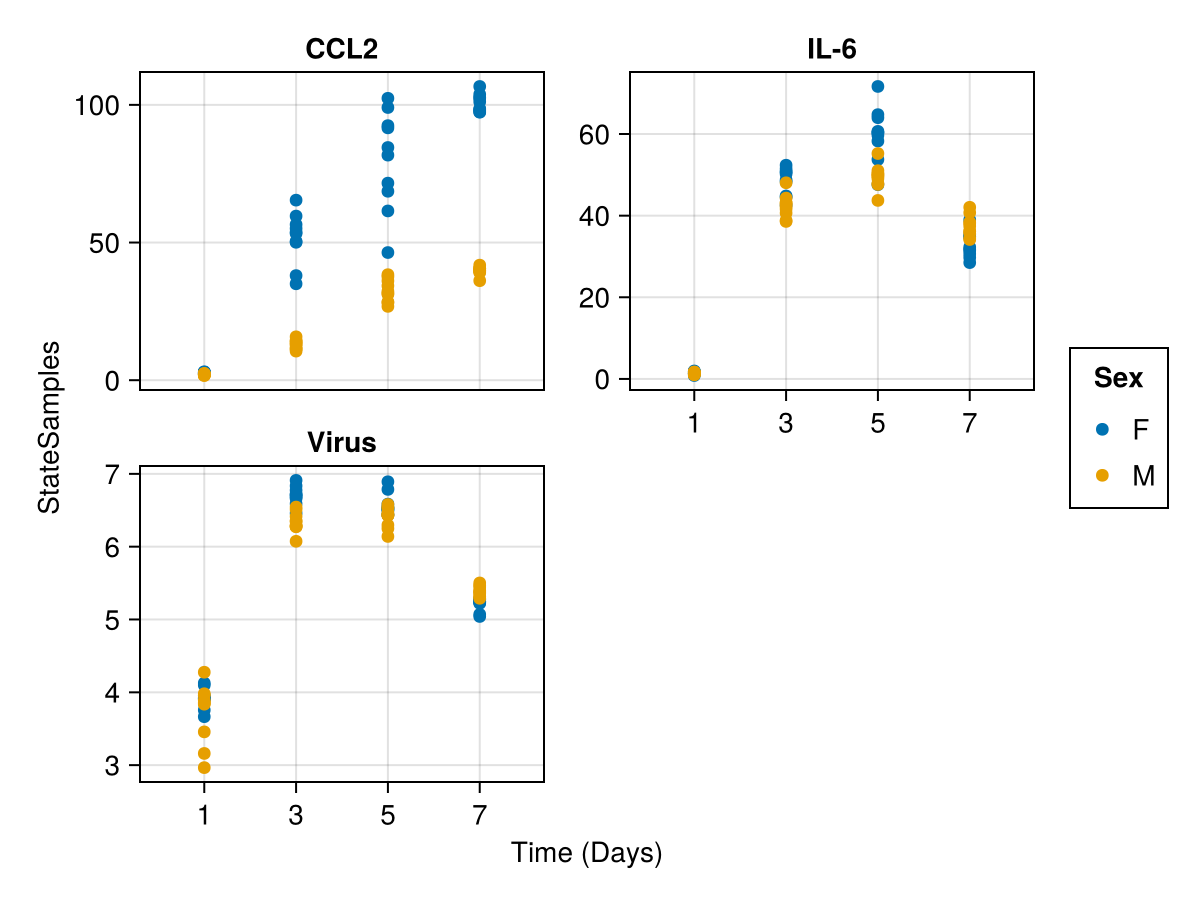

In [3]:
# Plot the generated data
using AlgebraOfGraphics, CairoMakie
fig = draw(
    AlgebraOfGraphics.data(
        df_samples 
    ) * 
    mapping(
        Symbol("Time (Days)") => string,
        :StateSamples,
        color = :Sex,
        layout = :State
    ) *
    visual(AlgebraOfGraphics.Scatter);
    facet=(; linkyaxes = :none)
)

# Creating an architecture and fitting the NN

The published model is as follows: 

\begin{align}
 &\frac{dV}{dt} = k \cdot V \cdot \left( 1 - \frac{V}{K}\right) - r_{v, ifn} \cdot IFN \cdot V \cdot M - d_v \cdot V \\
&\frac{dIFN}{dt} = \frac{k_1 \cdot V^n}{k_2 + V^n} + r_{ifn, m} \cdot M - d_{ifn} \cdot IFN \\
&\frac{dM}{dt} = r_{M, ifn} \cdot IFN - d_{M} \cdot M \\
\end{align}


A reasonable set of assumptions behind known mechanisms can be-
- Virus experiences a logistic growth
- All states undergo first order degradation

Based on these assumptions, we can construct the following architecture-

\begin{align} 
&\frac{dV}{dt} = k \cdot V \cdot \left(1 - \frac{V}{K}\right) + g_{v}(t, \theta_g) - d_v \cdot V \\
&\frac{dIFN}{dt} = g_{ifn}(t, \theta_g) - d_{ifn} \cdot IFN \\
&\frac{dM}{dt} = g_{m}(t, \theta_g) - d_{M} \cdot M \\
\end{align}

where $g:\mathbb{R}\to\mathbb{R}^3,\quad t\mapsto g(t;\,\theta_g)$

In [4]:
struct LiparuloKnownParams{T<:AbstractFloat}
    k::T
    K::T
    d_v::T
    d_ifn::T
    d_m::T
end

# function GreyBoxModel(
#         y::AbstractVecOrMat{<:Real}, p, g::AbstractVecOrMat{:<Real}, architecture::Function
#     )
#     # NOT SURE WHAT THIS FUNCTION'S PURPOSE IS FOR NOW?
#     return architecture(y, g, p)
# end

function LiparuloArchitecture(
        y::AbstractMatrix{<:Real},
        g::AbstractMatrix{<:Real},
        p::LiparuloKnownParams,
    )
    # Sanity Checks
    @assert size(y,1) == 3 "y must have 3 states (V, IFN, M)"
    @assert size(g,1) == 3 "g must be 3xB"

    V, IFN, M = y

    function LogisticGrowthRate(
            x,
            growth_rate,
            carrying_capacity
            )
        growth_rate .* x .* (1 - x./carrying_capacity)
    end

    dV = LogisticGrowthRate(V, p.k, p.K) .+ g[1, :] .- p.d_v .* V
    dIFN = g[2, :] .- p.d_ifn .* IFN
    dM = g[3, :] .- p.d_m .* M
    
    return permutedims(hcat(dV, dIFN, dM))
end

using Lux, NNlib 

State_MLP = Lux.Chain(
    Lux.Dense(1, 8, tanh),
    Lux.Dense(8, 3, NNlib.softplus)
)

ps_StateMLP, st_StateMLP = Lux.setup(rng, State_MLP)
g_MLP = Lux.Chain(
    Lux.Dense(1, 8, tanh),
    Lux.Dense(8, 3, tanh)
)
ps_gMLP, st_gMLP = Lux.setup(rng, g_MLP)

((layer_1 = (weight = Float32[-2.3806338; 1.9134449; … ; 2.7373414; 1.5088892;;], bias = Float32[0.0058715343, -0.65356565, 0.65263605, -0.9415729, 0.6586077, 0.9633372, -0.83269715, -0.5100539]), layer_2 = (weight = Float32[-0.6987005 -0.19117804 … 0.1940163 -0.8411807; -0.8951735 0.059530675 … 0.89828944 0.6252793; 0.23695129 -0.6343061 … 0.5515914 -0.34073365], bias = Float32[0.30486104, -0.022040863, 0.32793003])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [5]:
using ComponentArrays
using Optimization, OptimizationOptimisers
using Zygote
using ForwardDiff

# Create a dense t grid
t_dense = Float32.(range(first(t_train), last(t_train), length=200) |> collect)
t_dense = permutedims(t_dense)

# t_span to incorporate information at t = 0
t_span = [0f0, Float32.(t_train[end])]

# Initial Conditions

y0_init = [1f0, 1f0, 1f0]

# guess values for known physics
guess_LiparuloArchitecture = LiparuloKnownParams(
    50f0,
    1000f0,
    1f0,
    1f0,
    1f0
)

LiparuloKnownParams{Float32}(50.0f0, 1000.0f0, 1.0f0, 1.0f0, 1.0f0)

In [6]:
λ_ic  = 1.0f0 * 1000
λ_ode = 20.0f0 
λ_Data = 20.0f0


trainable_params = ComponentArrays.ComponentArray(
    StateMLP = ps_StateMLP,
    gMLP     = ps_gMLP,
    ODE_par  = (
        k = guess_LiparuloArchitecture.k,
        K = guess_LiparuloArchitecture.K,
        d_v = guess_LiparuloArchitecture.d_v,
        d_ifn = guess_LiparuloArchitecture.d_ifn,
        d_m = guess_LiparuloArchitecture.d_m
        ),
    #hyperparams = (λ_ode = λ_ode, λ_Data = λ_Data)
)

MSE(ŷ, y) = Statistics.mean(abs2, vec(ŷ .- y))

function MSE(ŷ, y, denom)  # normalized MSE
    t = vec((ŷ .- y) ./ denom)
    Statistics.mean(abs2, t)
end

#--------Training--------

ctx_stage1 = (
    State_MLP   = State_MLP,
    st_StateMLP = st_StateMLP,
    t_train     = t_train,
    Y_train     = Y_train,
    Y_train_std = Y_train_std,
    y0_obs      = y0_init,
    λ_ic        = λ_ic,
    λ_Data      = λ_Data,
    λ_ode       = λ_ode,
    t_span      = t_span
)

ctx_stage2 = (
    State_MLP   = State_MLP,
    st_StateMLP = st_StateMLP,
    g_MLP       = g_MLP,
    st_gMLP     = st_gMLP,
    t_train     = t_train,
    Y_train     = Y_train,
    Y_train_std = Y_train_std,
    y0_obs      = y0_init,
    λ_ic        = λ_ic,
    λ_Data      = λ_Data,
    λ_ode       = λ_ode,
    t_dense     = t_dense,
    t_span      = t_span,
    ODE_par_bounds = (
        k = [1f0, 100f0],
        K = [1f0, 2000f0],
        d_v = Float32.([1e-05, 10]),
        d_ifn = Float32.([1e-03, 1000]),
        d_m = Float32.([1e-03, 100])
    )
)

println(size(trainable_params))

(91,)


In [7]:

# bound_loss(trainable_params, ctx_stage2)

In [8]:
# Supervised loss (fit to data)
function loss_supervised(ps, ctx)
    smodel = Lux.StatefulLuxLayer(ctx.State_MLP, ps.StateMLP, ctx.st_StateMLP)
    ŷ = smodel(ctx.t_train)
    data_mse = MSE(ŷ, ctx.Y_train, ctx.Y_train_std)
    ic_mse   = MSE(smodel([ctx.t_span[1]]'), ctx.y0_obs, ctx.Y_train_std)
    return data_mse + ctx.λ_ic * ic_mse
end

using ForwardDiff

# 3×B Jacobian of smodel wrt scalar time, computed columnwise
dNNdt_fd(smodel, tvec::AbstractVector) = begin
    cols = map(tn -> begin
        J = Zygote.forwarddiff(x -> smodel(reshape(x, 1, :)), [tn])  # 3×1
        vec(J)  # 3
    end, tvec)
    reduce(hcat, cols)  # 3×B
end


dist_outside(x, lower, upper) = sum(@. max(0f0, lower - x) + max(0f0, x - upper))

function bound_loss(ps, ctx; scale=1000f0)
    p = ps.ODE_par
    b = ctx.ODE_par_bounds
    keys = propertynames(b)  # must match p

    # This is shorthand for mapreduce(f, +, keys) where f is the stuff inside the do block
    
    total = mapreduce(+, keys) do k
        x = getproperty(p, k)
        lo, hi = getproperty(b, k)  # b.k is a 2-element container
        dist_outside(x, lo, hi)
    end
    return scale * total
end

# ODE-regularized loss (data + residual + IC)
function loss_unsupervised(ps, ctx, architecture, ODE_params, bound_loss_function::Function=bound_loss)
    smodel = Lux.StatefulLuxLayer(ctx.State_MLP, ps.StateMLP, ctx.st_StateMLP)
    gmodel = Lux.StatefulLuxLayer(ctx.g_MLP,     ps.gMLP,     ctx.st_gMLP)

    par = ps.ODE_par
    ODE_par = ODE_params(par.k, par.K, par.d_v, par.d_ifn, par.d_m)


    Tdense = ctx.t_dense  # 1xN Matrix for now

    dNNdt = dNNdt_fd(smodel, vec(Tdense))         # 3×B
    f_ŷ   = architecture(smodel(Tdense), gmodel(Tdense), ODE_par)

    ode_mse  = MSE(dNNdt, f_ŷ, ctx.Y_train_std)
    data_mse = MSE(smodel(ctx.t_train), ctx.Y_train, ctx.Y_train_std)
    ic_mse   = MSE(smodel([ctx.t_span[1]]'), ctx.y0_obs, ctx.Y_train_std)

    return ctx.λ_ode * ode_mse + ctx.λ_Data * data_mse + ctx.λ_ic * ic_mse + bound_loss_function(ps, ctx)
end

loss_unsupervised (generic function with 2 methods)

In [9]:
ctx_stage2.ODE_par_bounds

(k = Float32[1.0, 100.0], K = Float32[1.0, 2000.0], d_v = Float32[1.0f-5, 10.0], d_ifn = Float32[0.001, 1000.0], d_m = Float32[0.001, 100.0])

In [10]:
Zygote.jacobian(x -> loss_unsupervised(x, ctx_stage2, LiparuloArchitecture, LiparuloKnownParams), trainable_params)[1]

1×91 Matrix{Float32}:
 289.282  8658.72  98.9729  1422.02  …  -1076.42  4.51982f-5  0.051456

In [11]:
optfun1 = Optimization.OptimizationFunction(
    (θ, p) -> loss_supervised(θ, p),
    Optimization.AutoZygote()
)

prob1 = Optimization.OptimizationProblem(
    optfun1, 
    trainable_params, 
    ctx_stage1
)
res1 = Optimization.solve(
    prob1,
    OptimizationOptimisers.Adam(1e-03);
    maxiters = 3_000
)

retcode: Default
u: ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-0.8339147; 0.39221388; … ; 1.0264124; 0.73830044;;], bias = Float32[0.0731747, 0.8070873, 0.503084, -0.76639235, -0.48681718, 0.38599393, -1.1116816, 0.34097314]), layer_2 = (weight = Float32[-0.50002134 0.852602 … 0.42569432 0.57114077; -2.774271 2.0366888 … 2.8260846 1.6562275; -2.1698005 2.7584362 … 3.1960945 3.887525], bias = Float32[0.4984972, 1.9738162, 0.6507393])), gMLP = (layer_1 = (weight = Float32[-2.3806338; 1.9134449; … ; 2.7373414; 1.5088892;;], bias = Float32[0.0058715343, -0.65356565, 0.65263605, -0.9415729, 0.6586077, 0.9633372, -0.83269715, -0.5100539]), layer_2 = (weight = Float32[-0.6987005 -0.19117804 … 0.1940163 -0.8411807; -0.8951735 0.059530675 … 0.89828944 0.6252793; 0.23695129 -0.6343061 … 0.5515914 -0.34073365], bias = Float32[0.30486104, -0.022040863, 0.32793003])), ODE_par = (k = 50.0f0, K = 1000.0f0, d_v = 1.0f0, d_ifn = 1.0f0, d_m = 1.0f0))

In [27]:
trainable_params_post_stage1 = res1.u

loss_closure = (x, p) -> loss_unsupervised(x, p, LiparuloArchitecture, LiparuloKnownParams)

optfun2 = Optimization.OptimizationFunction(
    (θ, p) -> loss_closure(θ, p),
    Optimization.AutoZygote()
)

prob2 = Optimization.OptimizationProblem(
    optfun2,
    trainable_params_post_stage1, 
    ctx_stage2
)

res2 = Optimization.solve(
    prob2, 
    OptimizationOptimisers.Adam(5e-04); 
    maxiters=50000
)
ps_trained = res2.u

ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-1.7452146; -0.9648111; … ; 1.6751658; -0.16652185;;], bias = Float32[0.8876859, 0.51849854, 1.323697, -2.6634028, -1.7368364, 1.1431762, -3.2292, 1.0602814]), layer_2 = (weight = Float32[1.2969639 1.7485731 … 2.8375843 0.8367591; -11.0683365 -4.570503 … 11.425355 9.670264; -5.9670405 3.9903188 … 9.859493 8.936821], bias = Float32[1.2501653, 10.203608, 7.7151437])), gMLP = (layer_1 = (weight = Float32[-1.6783012; 2.2414463; … ; 1.5742756; 2.0283856;;], bias = Float32[3.8660183, -0.3118661, 3.4697483, -0.44858626, 0.72869164, -2.0462708, -3.3749876, 0.0040597436]), layer_2 = (weight = Float32[-1.5328871 0.1641686 … 0.876958 -0.4833134; -0.6061447 1.7799541 … 1.1906047 2.3509457; 0.22028355 1.3063769 … 1.2106997 1.6036884], bias = Float32[0.6580179, 1.6931753, 2.2651691])), ODE_par = (k = 48.269924f0, K = 999.76306f0, d_v = 2.7271674f0, d_ifn = 0.0010509137f0, d_m = 0.001418205f0))

In [28]:
# --- Build the post-fit (stage 2) state model ---
# ps_trained comes from res2.u in your code
smodel = Lux.StatefulLuxLayer(State_MLP, ps_trained.StateMLP, st_StateMLP)

t_plot = Float32.(range(first(t_span), last(t_span), length=200) |> collect)
t_plot = permutedims(t_plot)
# Make sure time is a Vector{<:Real}
tvec = vec(t_plot)  # if t_train is 1×N, vec() makes it N
ŷ = smodel(t_plot)
ŷ_plot = ŷ
Y_plot = Y_train

# NN prediction (3×N)


N = length(tvec)
labels = ["Virus","IL-6","CCL2"]  # rename as you like: e.g., ["S","I","R"]

df_pred = DataFrame(
    Symbol("Time (Days)") => repeat(tvec, 3),
    :State   => vcat(fill(labels[1], N), fill(labels[2], N), fill(labels[3], N)),
    :StateValues  => vcat(eachrow(ŷ_plot)...),
    :Source => "NN"
);



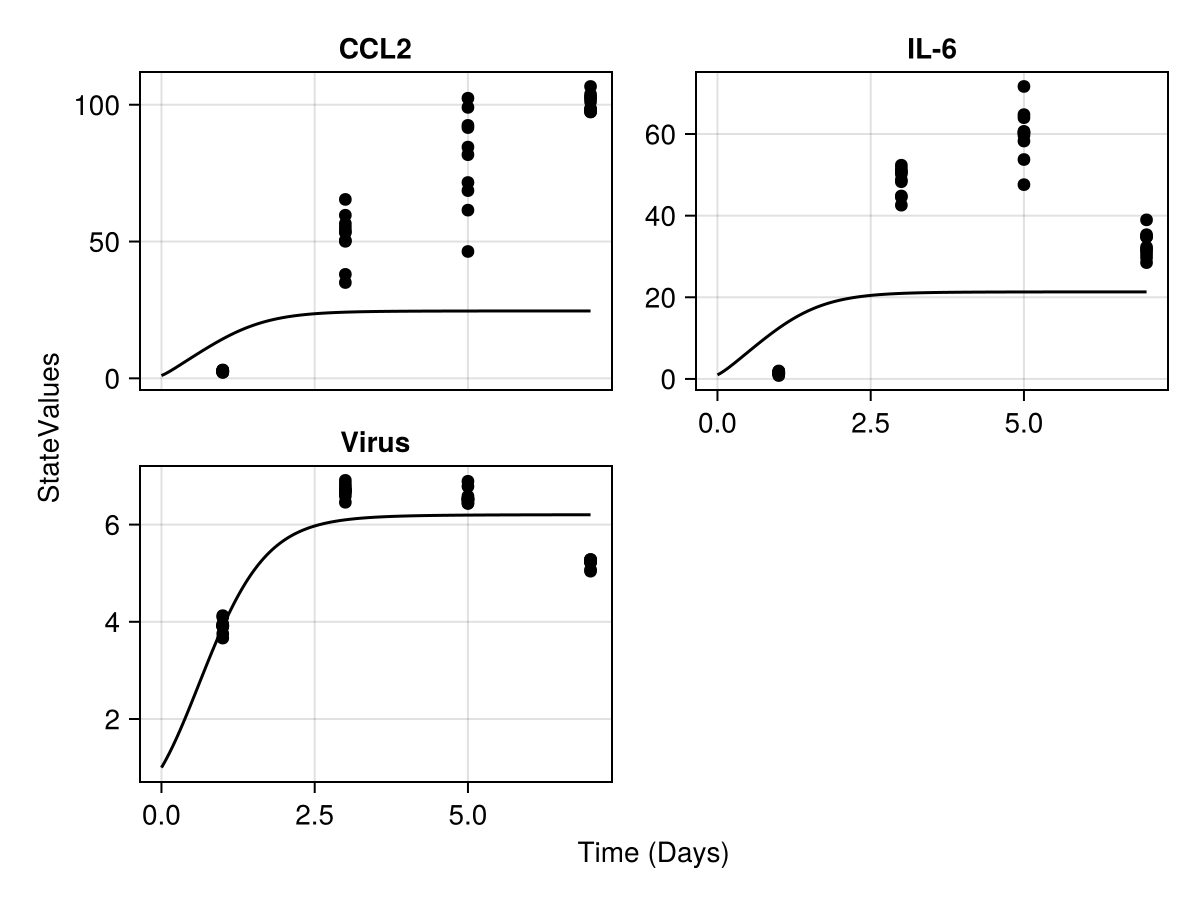

In [29]:
plot_df = DataFrame(df_samples)
plot_df.Source .= "Data";

subset!(
    plot_df,
    :Sex => ByRow(
        in(["F"])
    )
) 
select!(plot_df, Not([:Sex, :SampleID]))
rename!(plot_df, :StateSamples => :StateValues)
# select!(plot_df, Not())


plot_df = vcat(plot_df, df_pred)


draw(
    (
        AlgebraOfGraphics.data(
            plot_df[plot_df.Source .== "Data", :]
            ) * 
        mapping(
            Symbol("Time (Days)"),
            :StateValues,
            layout = :State
            ) *
        visual(AlgebraOfGraphics.Scatter)
    ) + 
    (
        AlgebraOfGraphics.data(
            plot_df[plot_df.Source .== "NN", :]
            ) * 
        mapping(
            Symbol("Time (Days)"),
            :StateValues,
            layout = :State
            ) *
        visual(AlgebraOfGraphics.Lines)
    )
    ;
    facet=(; linkyaxes = :none)
)

In [22]:
Y_train;
smodel(t_train)[2, :]

40-element Vector{Float32}:
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 12.439373
 20.953642
 20.953642
 20.953642
  ⋮
 21.304644
 21.304644
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669
 21.324669

In [25]:
MSE(Y_train[3,:], smodel(t_train)[3,:], Y_train_std[3])

1.0456465f0